In [1]:
! eups list -s | grep lsst_distrib

eups                  LOCAL:/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2021_21/conda/miniconda3-py38_4.9.2/envs/lsst-scipipe-0.6.0-ext/eups 	setup
lsst_distrib          21.0.0-2-g8e5b5ee+0374c0674c 	w_latest current w_2021_21 setup


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.afw.image as afwImage
from astropy.table import Table
from lsst.ip.isr.isrTask import IsrTask


In [3]:
def display(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(exposure.getImage())
    plt.title(title)
    plt.gca().axis('off')

List data in this collections

In [4]:
repo_path = "/sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/butler.yaml"
collections = 'u/jchiang/calib/bias/run_12781/20210525T184949Z'.split(",")

butler = Butler(repo_path)
registry = butler.registry
    
subbutler = Butler(repo_path,collections=collections)
subregistry = subbutler.registry
print(subregistry)
for dtype in subregistry.queryDatasetTypes():
    try:
        datasetRefs = list(subregistry.queryDatasets(datasetType=dtype,collections=collections))
        print(len(datasetRefs), dtype )
    except:
        print("Error", dtype )

SQLite3@/sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/gen3.sqlite3
0 DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
243 DatasetType('cpBiasProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
243 DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
3 DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
3 DatasetType('cpCombine_metadata', {instrument, detector}, PropertySet)
1 DatasetType('isr_config', {}, Config)
1 DatasetType('cpCombine_config', {}, Config)
1 DatasetType('packages', {}, Packages)
0 DatasetType('camera', {instrument}, Camera, isCalibration=True)
0 DatasetType('cpDarkIsr', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpDarkProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('cpDark_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
0 Data

Get a bias

In [5]:
where = """
instrument='LSSTCam'
and detector=96
"""
collections ="u/jchiang/calib/bias/run_12781/20210525T184949Z"

subbutler = Butler(repo_path,collections=collections)
subregistry = subbutler.registry

atyp = "bias"
datasetRefs = list(subregistry.queryDatasets(
    datasetType=atyp,collections=collections,where=where
))

biases = []
for adatasetRef in datasetRefs:
    biases.append( subbutler.get(adatasetRef) )
biases

Get BFK for 96

In [6]:
where = """
instrument='LSSTCam'
and detector=96
"""
collections ="u/youtsumi/run_12781/bf_work_v5_v2/bfks/20210620T235809Z"

subbutler = Butler(repo_path,collections=collections)
subregistry = subbutler.registry

atyp = "bfk"
datasetRefs = list(subregistry.queryDatasets(
    datasetType=atyp,collections=collections,where=where
))

bfk = []
for adatasetRef in datasetRefs:
    bfk.append( subbutler.get(adatasetRef) )
bfk

Do ISR

{instrument: 'LSSTCam', detector: 96, exposure: 3020112300165, ...} / 2400


/sdf/group/lsst/camera/IandT/rawData/focal-plane/20201123/MC_C_20201123_000165/MC_C_20201123_000165_R22_S20.fits(MC_C_20201123_000165): Unable to determine the filter


R22_S20 AMP


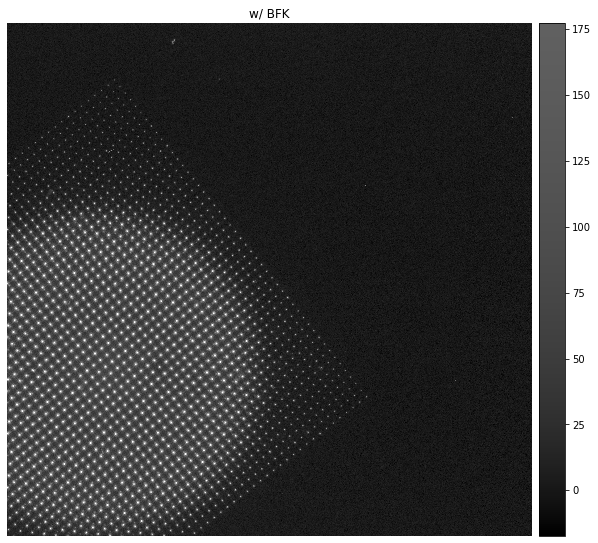

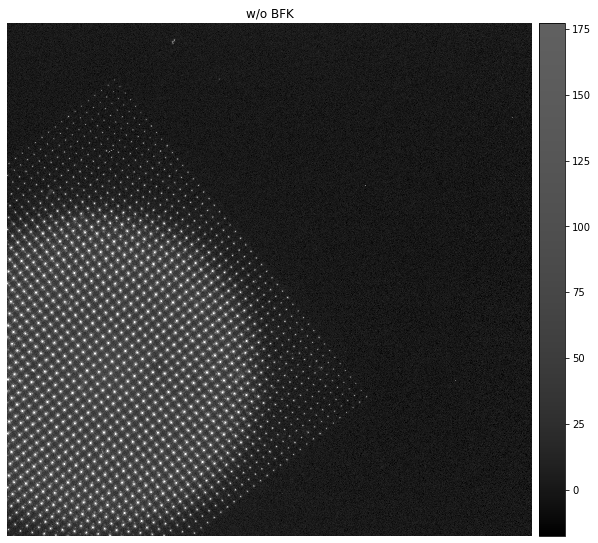

In [7]:
where = """
instrument='LSSTCam'
and detector=96
and exposure.observation_type='spot'
and exposure.science_program IN ('12784')
"""
collections = 'u/jchiang/calib/bias/run_12781/20210525T184949Z,u/abrought/run_12781/bf_work_v5/polynomialfit/spots_v10/wbfcorr'.split(",")

subbutler = Butler(repo_path,collections=collections)
subregistry = subbutler.registry

# get an array of raw images
atyp = "raw"
datasetRefs = list(subregistry.queryDatasets(
    datasetType=atyp,collections=collections,
    where = where
))

i=0
print(datasetRefs[i].dataId, "/", len(datasetRefs))
raw = subbutler.get(datasetRefs[i])

# It didn't work by supplying BFK as an input of bfKernel. I digged into the code and it turned out it needed to make detector level brighter fatter kernel and passed it to as a numpy.ndarray. The following cell is to prepare it
# https://github.com/lsst/ip_isr/blob/c8894c71d8ece4ba74a0eec7ca2cdacfc997e8ea/python/lsst/ip/isr/isrTask.py#L1014
detName = raw.getDetector().getName()
level = bfk[0].level
bfk[0].makeDetectorKernelFromAmpwiseKernels(detName)
print(detName,level)

# Do ISR with BFK correction
isr = IsrTask()
isr.config.doLinearize=False
isr.config.doDark=False
isr.config.doBias=True        
isr.config.doFlat=False
isr.config.doDefect=False
isr.config.doBrighterFatter=True

postISRCCD = isr.run(raw,bias=biases[0],bfKernel=bfk[0].detKernels[detName])
display(postISRCCD.exposure,"w/ BFK")
plt.show()

# Do ISR WITHOUT BFK correction
isr = IsrTask()
isr.config.doLinearize=False
isr.config.doDark=False
isr.config.doBias=True        
isr.config.doFlat=False
isr.config.doDefect=False
isr.config.doBrighterFatter=False

postISRCCDwoBFK = isr.run(raw,bias=biases[0])
display(postISRCCDwoBFK.exposure,"w/o BFK")
plt.show()



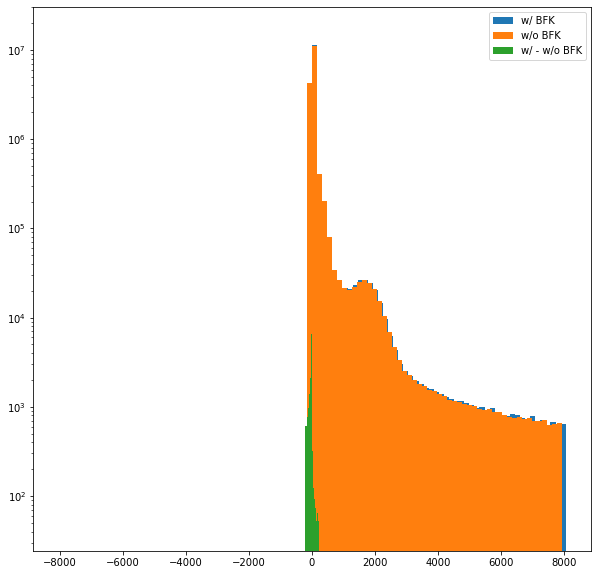

In [8]:
print(postISRCCD.exposure)

fig = plt.figure(figsize=(10,10))


for a, l in [ 
    ( postISRCCD.exposure.image.array.flatten(), "w/ BFK"),
    ( postISRCCDwoBFK.exposure.image.array.flatten(), "w/o BFK"),
    ( (postISRCCD.exposure.image.array-postISRCCDwoBFK.exposure.image.array).flatten(), "w/ - w/o BFK")
    ]:
    plt.hist(
        a,range=(-3*a.std(),3*a.std()),
        bins=100,
        label=l
    )
plt.semilogy()
plt.legend()


So they are different, which means it applies something... hopefully brighter fatter kernel